In [1]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image
import warnings
import numpy as np

# disable some warnings
transformers.logging.set_verbosity_error()
transformers.logging.disable_progress_bar()
warnings.filterwarnings('ignore')

In [45]:
from depth_estimation.depth_anything.dpt import DepthAnything
from pathlib import Path
import os
import cv2
from PIL import Image

# set device
device = 'cuda'  # or cpu

root_path = Path(os.getcwd()).parents[0]
weights_path_dict = {
    'v1': {
        "vits": root_path / "tmp/model-weights/depth_anything_v1_vits.pth",
        "vitb": root_path / "tmp/model-weights/depth_anything_v1_vitb.pth",
        "vitl": root_path / "tmp/model-weights/depth_anything_v1_vitl.pth",
    },
    'v2': {
        "vits": root_path / "tmp/model-weights/depth_anything_v2_vits.pth",
        "vitb": root_path / "tmp/model-weights/depth_anything_v2_vitb.pth",
        "vitl": root_path / "tmp/model-weights/depth_anything_v2_vitl.pth",
    },
}

model_configs = {
    "vits": {"encoder": "vits", "features": 64, "out_channels": (48, 96, 192, 384)},
    "vitb": {"encoder": "vitb", "features": 128, "out_channels": (96, 192, 384, 768)},
    "vitl": {
        "encoder": "vitl",
        "features": 256,
        "out_channels": (256, 512, 1024, 1024),
    },
    "vitg": {
        "encoder": "vitg",
        "features": 384,
        "out_channels": (1536, 1536, 1536, 1536),
    },
}

def load_depth_anything(path, configs, device):

    model = DepthAnything(**configs)
    model.load_state_dict(torch.load(path, 
                                     map_location='cpu',
                                     weights_only=True))
    model = model.to(device)
    model.eval()
    return model


depth_anything = load_depth_anything(weights_path_dict['v2']['vitb'], model_configs['vitb'], device)

image1_path = '/home/artem-trybushenko/Downloads/Hand-eye-Calibration-Experiment.png'
image1_path = '/home/artem-trybushenko/Downloads/rgb.jpg'
image1 = cv2.imread(image1_path)

depth = depth_anything.infer_image(image1)
# depth = depth / depth.max()
depth = (depth - depth.min()) / (depth.max() - depth.min())
depth = (depth * 255).astype(np.uint8)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image1 = Image.fromarray(image1)
image2 = depth
# image2 = Image.fromarray(cv2.applyColorMap(depth, cv2.COLORMAP_JET), 'RGB')

image1 = Image.open('/home/artem-trybushenko/Downloads/rgb.jpg')
# image2 = Image.open('/home/artem-trybushenko/Downloads/depth.png')


In [ ]:
def s()

255

<Axes: ylabel='Count'>

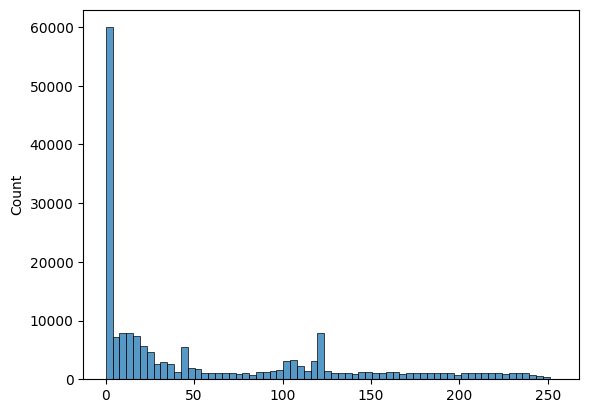

In [47]:
import seaborn as sns   

sns.histplot(image2.flatten())

In [42]:
cv2.imread('/home/artem-trybushenko/Downloads/depth.png').flatten().shape

(562500,)

<Axes: ylabel='Count'>

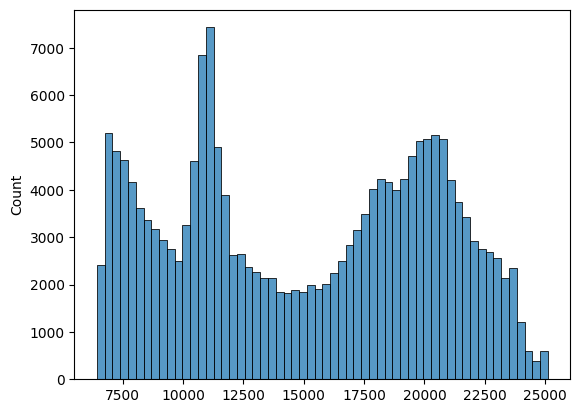

In [44]:
sns.histplot(np.array(Image.open('/home/artem-trybushenko/Downloads/depth.png')).flatten())

In [3]:
A = 1 / image2.min() - 1 / image2.max()
B = 1 / image2.max()

d = 1 / (A * image2 + B)

In [52]:
image1 = Image.open('/home/artem-trybushenko/Downloads/rgb.jpg')
image2 = Image.open('/home/artem-trybushenko/Downloads/depth.png')

In [5]:
# set device
device = 'cuda'  # or cpu

model_name = 'RussRobin/SpatialBot-3B'
offset_bos = 0

# create model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16, # float32 for cpu
    device_map='auto',
    trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True)


In [ ]:
# text prompt
prompt = 'Do not take into account the RGB image. Take into account the depth image. What is the distance between the robotic arm and box on the background?'
text = f"A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. The assistant give highly technical responses to the user in depth values, meters and millimeters. USER: <image 1>\n<image 2>\n{prompt} ASSISTANT:"
text_chunks = [tokenizer(chunk).input_ids for chunk in text.split('<image 1>\n<image 2>\n')]
input_ids = torch.tensor(text_chunks[0] + [-201] + [-202] + text_chunks[1][offset_bos:], dtype=torch.long).unsqueeze(0).to(device)

image1 = Image.open('/home/artem-trybushenko/Downloads/rgb.jpg')
image2 = Image.open('/home/artem-trybushenko/Downloads/depth.png')

channels = len(image2.getbands())
if channels == 1:
    img = np.array(image2)
    height, width = img.shape
    three_channel_array = np.zeros((height, width, 3), dtype=np.uint8)
    three_channel_array[:, :, 0] = (img // 1024) * 4
    three_channel_array[:, :, 1] = (img // 32) * 8
    three_channel_array[:, :, 2] = (img % 32) * 8
    image2 = Image.fromarray(three_channel_array, 'RGB')

image_tensor = model.process_images([image1,image2], model.config).to(dtype=model.dtype, device=device)

# If 'Expected all tensors to be on the same device' error is thrown, uncomment the following line
model.get_vision_tower().to('cuda')

# generate
output_ids = model.generate(
    input_ids,
    images=image_tensor,
    max_new_tokens=100,
    use_cache=True,
    repetition_penalty=1.0 # increase this to avoid chattering
)[0]

print(tokenizer.decode(output_ids[input_ids.shape[1]:], skip_special_tokens=True).strip())

1
The robotic arm and box on the background are at a similar depth, indicating they are relatively close to each other.


In [50]:
len(image2.getbands())

3

In [1]:
from transformers import AutoTokenizer, AutoModel
import torch


# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
model = AutoModel.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, max pooling.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

print("Sentence embeddings:")
print(sentence_embeddings)


tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

Sentence embeddings:
tensor([[ 0.1885,  0.1743,  0.0545,  0.2905,  0.1677, -0.0472,  0.6456,  0.1598,
          0.2269, -0.0309,  0.2559, -0.0526, -0.2261, -0.0571,  0.1304,  0.1250,
          0.3175,  0.1944, -0.5863, -0.0126,  0.6099,  0.1643,  0.0333, -0.2738,
         -0.2898, -0.2112, -0.0226, -0.1704,  0.1616,  0.0608, -0.2416,  0.1858,
          0.4274,  0.1930, -0.0723,  0.1661,  0.1044,  0.2048,  0.2112,  0.1997,
         -0.0941, -0.1738,  0.0643,  0.2803, -0.2953,  0.0621,  0.1043, -0.0236,
          0.1291, -0.1262, -0.1790,  0.0370, -0.6125,  0.0503,  0.1773,  0.2249,
          0.1739, -0.0384, -0.2129,  0.2585, -0.1210,  0.3097, -0.4197,  0.0091,
          0.1419, -0.3056,  0.1762, -0.0709, -0.6203,  0.6771,  0.0172,  0.1841,
         -0.1679,  0.2045, -0.1477, -0.0618,  0.6302,  0.1112,  0.0515,  0.1593,
         -0.0537,  0.0535,  0.1414,  0.1124, -0.4841, -0.1699, -0.0532,  0.2765,
          0.1178, -0.3491, -0.5138, -0.3284,  0.5424, -0.0533,  0.2292, -0.0128,
       